            Q (m3/s)
Date                
1996-01-01    2070.0
1996-01-02    2010.0
1996-01-03    1990.0
1996-01-04    1980.0
1996-01-05    1970.0
            Q (m3/s)
Date                
2016-12-28    2490.0
2016-12-29    2455.0
2016-12-30    2420.0
2016-12-31    2374.0
(7671, 1)
Training 5844, Test 1827
Date
1996-01-01    2070.0
1996-01-02    2010.0
1996-01-03    1990.0
1996-01-04    1980.0
1996-01-05    1970.0
1996-01-06    1950.0
1996-01-07    1950.0
1996-01-08    1940.0
1996-01-09    1930.0
1996-01-10    1920.0
1996-01-11    1900.0
1996-01-12    1870.0
1996-01-13    1830.0
1996-01-14    1820.0
1996-01-15    1760.0
1996-01-16    1760.0
1996-01-17    1780.0
1996-01-18    1780.0
1996-01-19    1760.0
1996-01-20    1780.0
1996-01-21    1780.0
1996-01-22    1810.0
1996-01-23    1830.0
1996-01-24    1880.0
1996-01-25    1910.0
1996-01-26    1890.0
1996-01-27    1940.0
1996-01-28    1950.0
1996-01-29    1940.0
1996-01-30    1920.0
               ...  
2011-12-02    3639.0
2011-12-03    3

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


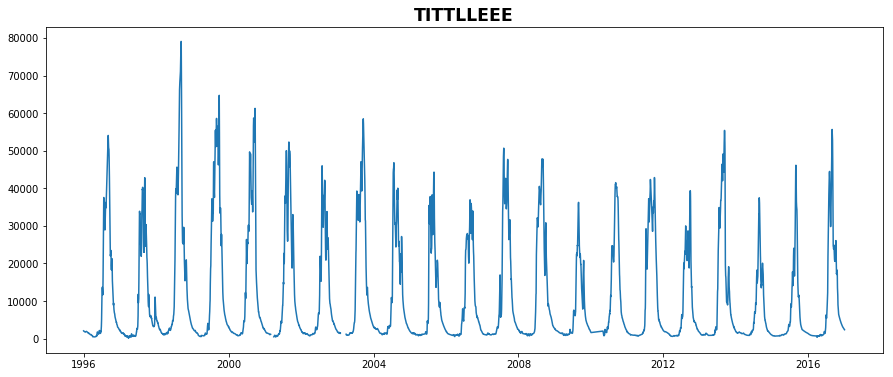

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from google.colab import files
import io
from statsmodels.tsa.arima_model import ARIMA

# Format data plots
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

# Import data set from Ganges_1996_2016  
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#data = pd.read_csv(io.BytesIO(uploaded['Ganges_1996_2016.csv']), parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data = pd.read_csv('http://kdl.cs.umb.edu/CS670/data/Ganges_1996_2016.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
# Check data has been properly parsed out
print(data.head())
print(data.iloc[-4:])
print(data.shape)

# Assign Data
qs = data['Q (m3/s)']
plt.title('TITTLLEEE')
plt.plot(qs)

# Split our data set
split_test = len(data) - 1827
ts, ts_test = qs[0:split_test], qs[split_test:]
print('Training %d, Test %d' % (len(ts), len(ts_test)))
print(ts)
print(ts_test)

In [ ]:
# Checking for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts):
  
    # Determing rolling statistics
    rawrolmean = ts.rolling(window=365, min_periods=310, center=False).mean()
    meanNoNuls = pd.notna(rawrolmean)
    rolmean = rawrolmean[meanNoNuls]
    rawrolstd = ts.rolling(window=365, min_periods=310, center=False).std()
    stdNoNuls = pd.notna(rawrolstd)
    rolstd = rawrolstd[stdNoNuls]
    
    # Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

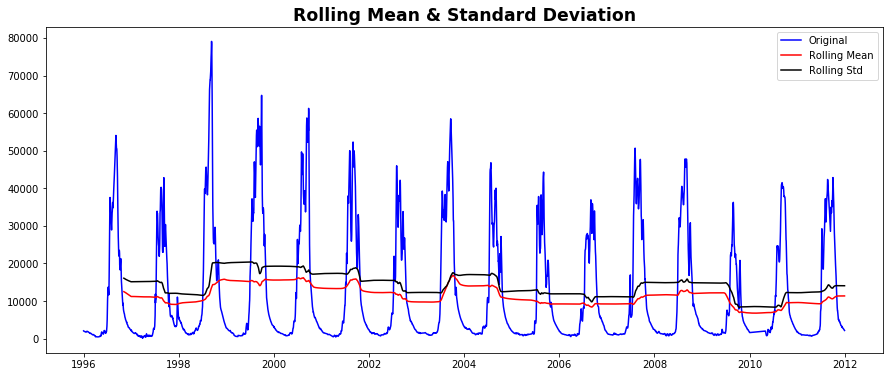

Results of Dickey-Fuller Test:
Test Statistic                -6.827082e+00
p-value                        1.935551e-09
#Lags Used                     3.100000e+01
Number of Observations Used    5.728000e+03
Critical Value (1%)           -3.431492e+00
Critical Value (5%)           -2.862045e+00
Critical Value (10%)          -2.567039e+00
dtype: float64


In [ ]:
ts.dropna(inplace=True)

test_stationarity(ts)

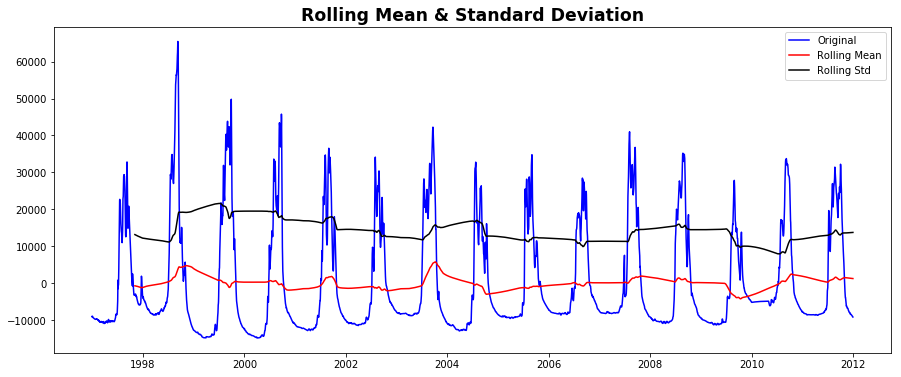

Results of Dickey-Fuller Test:
Test Statistic                -6.590401e+00
p-value                        7.138469e-09
#Lags Used                     3.100000e+01
Number of Observations Used    5.364000e+03
Critical Value (1%)           -3.431570e+00
Critical Value (5%)           -2.862079e+00
Critical Value (10%)          -2.567057e+00
dtype: float64


In [ ]:
# Factoring out rolling average
rolmean = ts.rolling(window=365, center=False).mean()
ts_mean_dif = ts - rolmean
ts_mean_dif.dropna(inplace=True)

test_stationarity(ts_mean_dif)

#this is not used, just a test to see how stationary it makes the data

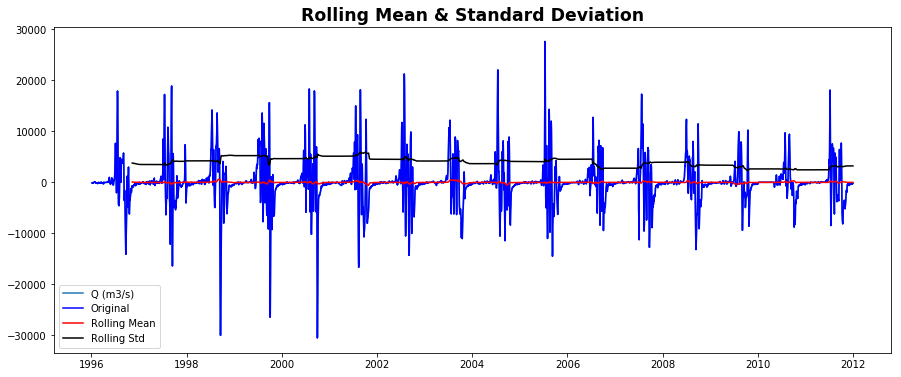

Results of Dickey-Fuller Test:
Test Statistic                -9.507514e+00
p-value                        3.316627e-16
#Lags Used                     3.400000e+01
Number of Observations Used    5.720000e+03
Critical Value (1%)           -3.431494e+00
Critical Value (5%)           -2.862045e+00
Critical Value (10%)          -2.567039e+00
dtype: float64


In [ ]:
# Using Differencing
periods = 5
ts_dif = ts - ts.shift(periods=periods)
plt.plot(ts_dif)

ts_dif.dropna(inplace=True)

test_stationarity(ts_dif)

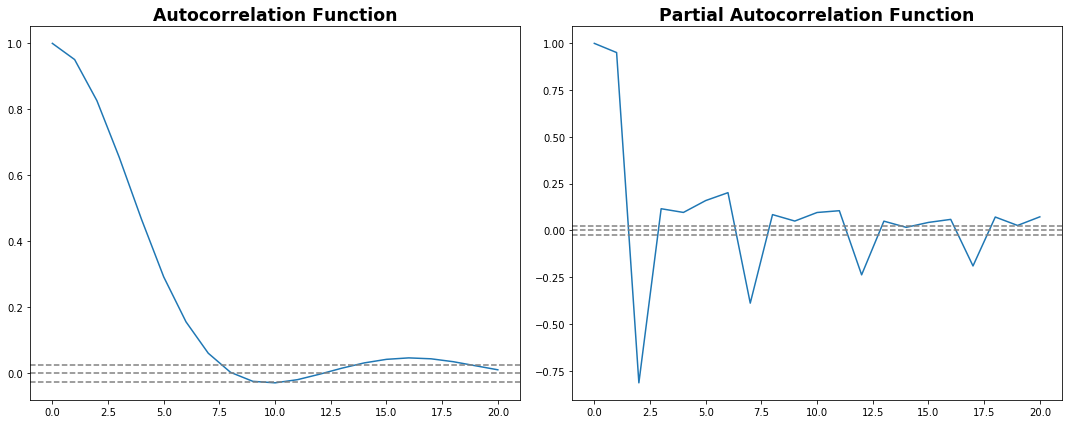

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_dif, nlags=20)
lag_pacf = pacf(ts_dif, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_dif)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_dif)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_dif)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_dif)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, periods):
  logy = yhat + history[periods] 
  #print("history:"+str(history[-periods])+"pred:"+str(logy)) 
  return logy, logy

In [ ]:
print (ts_test.shape)
print (ts_dif.shape)
model = ARIMA(ts_dif, order=(7, 1, 1))  
results_ARIMA = model.fit()
forecast = results_ARIMA.forecast(steps=1827)
print (forecast[0].shape)

(1827,)
(5755,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


(1827,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Our best result for ARIMA predictions using the best values for p,d, and q.

[ -242.09142678  -321.15634929  -397.1727238  ... -1096.84286604
 -1096.98138557 -1097.1199051 ]
[1246.9085732204119, 1138.8436507064503, 1045.8272762035513, 845.4750744692893, 617.120089032784, 441.46879060838705, 324.39348894972613, 236.65131546057034, 201.69028164146187, 167.64736281125784, 140.21452338565757, 156.99500420798302, 209.61988052535958, 207.7316566991609, 174.333343730406, 182.33013172607548, 210.55705554413737, 228.1031414003039, 256.93416817303444, 258.9931221894702, 281.66349556005684, 270.7764063923255, 282.14657470644465, 313.0927328899444, 312.12955924976075, 285.7825504667311, 263.376995969379, 238.06766318150665, 222.2657832821576, 210.6360628684654, 206.1166777552786, 191.50334629109182, 176.73603171903892, 173.0812788691976, 162.4103576164066, 165.43863454611312, 171.46208377261632, 162.06186211894817, 130.55426020231687, 116.98341011624655, 101.90212959352812, 102.99398564323303, 96.31415322208284, 113.57044119106081, 135.57409891850455, 173.40784353444167, 2

Text(0.5, 1.0, 'RMSE: 6037.5702')

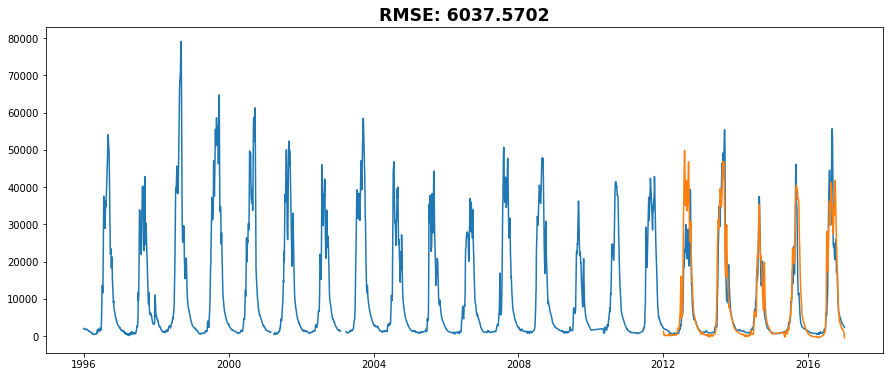

In [ ]:
#start = pd.to_datetime('2011-01-01', format='%Y-%m-%d')
#end = pd.to_datetime('2012-12-31', format='%Y-%m-%d')

#start = '2011-01-01'
#end = '2012-12-31'


#forecast = results_ARIMA.predict(start=start,end=end)
forecast = results_ARIMA.forecast(steps=1827)[0]
print(forecast)
history = [x for x in ts.values]
history = history[-len(forecast):]
predictions = []
for i in range(len(forecast)):
  yhat = forecast[i]
#for yhat in forecast:
  logy, inverted = inverse_difference(history, yhat, i+periods)
  history.append(logy)
  predictions.append(inverted)
predictions_ARIMA = pd.DataFrame(predictions,index = ts_test.index)
print(predictions)
#predictions_ARIMA = pd.DataFrame(predictions)
plt.plot(qs)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-ts_test.values)**2)/len(ts_test)))

The above is our best solution for predicting the next five years all at once, using the ARIMA model.  Below, we have the "one step out of sample" solution, in which each day in the test set is only predicted the day before, taking into account the true values for all the days in the test set leading up to it, as is done in the "one step out of sample" portion of the lecture notes.  While this gives much more accurate predictions the predictions can only be made one day at a time versus years ahead.


In [ ]:
def makeInLoopOneDay(p, d, q, test_x):
  warnings.filterwarnings("ignore")
  periods=5
  predictions = []
  for i in range(split_test,len(qs)):
    #shows we are still running
    if(i%50 == 0):
      print('.')
    history = qs[0:i]
    ts_difference = history - history.shift(periods=periods)
    ts_difference.dropna(inplace=True)
    model = ARIMA(ts_difference, order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=1)[0]
    logy, inverted = inverse_diff(history, forecast[0], periods)
    predictions.append(inverted)
  predictions_ARIMA = pd.DataFrame(predictions,index = ts_test.index)
  plt.plot(qs)
  plt.plot(predictions_ARIMA)
  plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-ts_test.values)**2)/len(ts_test)))

In [ ]:
# invert differenced value
def inverse_diff(history, yhat, periods):
  logy = yhat + history[-periods] 
  return logy, logy

Note: below takes a few hours to run, do not re-run unless necessary

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


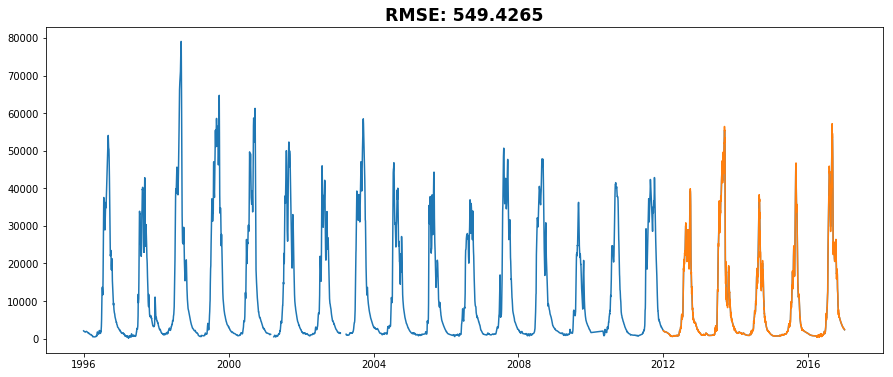

In [ ]:
#Run this only if required for maximum accuracy, this takes upto a half a day to finish running
#makeInLoopOneDay(7, 1, 1, ts)

This method is obviously much more accurate in its predictions, but requires that we only predict one day into the future at a time.  Therefore it is more accurate but not necessarily as useful, as it only provides the prediction the day before.